Final Code for Hybrid SHAP–Association Rule Explainability Framework (H-SARXAI) with trust scores 

In [1]:
import pandas as pd
import numpy as np
import time
import shap
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

warnings.filterwarnings("ignore")
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# ---------------------------
# SHAP-Compatible Wrapper
# ---------------------------
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]  # Add time step dimension
        return self.model(data).numpy()

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

# ---------------------------
# 2. Feature Scaling
# ---------------------------
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

# ---------------------------
# 3. Build GRU Model
# ---------------------------
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# 4. Bayesian Optimization
# ---------------------------
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=3)
    return optimizer.max['params']

# ---------------------------
# 5. Train & Evaluate Model
# ---------------------------
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# ---------------------------
# 6. Trust Score Computation
# ---------------------------
def compute_trust_metrics(shap_feats, rule_feats, k=10):
    shap_top_k = set(shap_feats[:k])
    rule_top = set(rule_feats)
    intersection = shap_top_k.intersection(rule_top)
    
    precision_at_k = len(intersection) / k
    coverage = len(intersection) / len(rule_top) if rule_top else 0
    jaccard = len(intersection) / len(shap_top_k.union(rule_top)) if shap_top_k.union(rule_top) else 0
    
    return precision_at_k, coverage, jaccard

# ---------------------------
# 7. Hybrid XAI with Trust Score
# ---------------------------
def hybrid_xai_analysis(model, X_2d, y, df, target_col):
    print("\n===== XAI Analysis (SHAP + Rules + Trust Score) =====")

    # --- SHAP ---
    wrapped_model = GRUModelWrapper(model)
    explainer = shap.Explainer(wrapped_model, X_2d)
    shap_vals = explainer(X_2d)

    # Ensure 1D indexing
    mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
    if mean_abs_shap.ndim > 1:
        mean_abs_shap = mean_abs_shap.mean(axis=0)  # Flatten if needed

    shap_top_idx = np.argsort(mean_abs_shap)[::-1]
    shap_top_feats = df.drop(columns=[target_col]).columns.to_numpy()[shap_top_idx].tolist()
    print("\nTop SHAP Features:", shap_top_feats[:10])

    # --- Association Rules ---
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    rule_top_feats = {}
    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Rule Features: {[f for f, _ in sorted_feats]}")

    # --- Overlap & Trust Metrics ---
    print("\n--- Trust Metrics per Class ---")
    for cls, feats in rule_top_feats.items():
        rule_feat_names = [f for f, _ in feats]
        precision, coverage, jaccard = compute_trust_metrics(shap_top_feats, rule_feat_names)
        print(f"Class {cls} → Precision@10: {precision:.2f}, Coverage: {coverage:.2f}, Jaccard: {jaccard:.2f}")

# ---------------------------
# 8. Main
# ---------------------------
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)

    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

    print("\nRunning Hybrid XAI...")
    hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

if __name__ == "__main__":
    main()



Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9837    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9146    | 63.56     | 0.219     | 11.68     | 32.49     |
| 4         | 0.9837    | 63.83     | 0.1911    | 29.64     | 127.8     |
| 5         | 0.9797    | 23.98     | 0.4888    | 11.7      | 116.6     |

Training Model...
Epoch 1/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4558 - loss: 1.2554 - val_accuracy: 0.4878 - val_loss: 1.0133
Epoch 2/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5246 - loss: 1.0177 - val_accuracy: 0.7520 - val_loss: 0.7962
Epoch 3/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7027 - loss: 0.8119 - val_accuracy: 0.7886 - val_loss: 0.6162
Epoch 4/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - a

ExactExplainer explainer: 1231it [02:41,  7.33it/s]                          



Top SHAP Features: ['fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2']

Class 1 Rule Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Rule Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Rule Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Rule Features: []

--- Trust Metrics per Class ---
Class 1 → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Class 2 → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Class 3 → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Class 0 → Precision@10: 0.00, Coverage: 0.00, Jaccard: 0.00


Printing number of samples per class

In [2]:
import pandas as pd

# File paths
train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Count instances per class in the target column 'fenologia_h2'
train_class_counts = train_df['fenologia_h2'].value_counts().sort_index()
test_class_counts = test_df['fenologia_h2'].value_counts().sort_index()

# Print results
print("Training Set Class Distribution:")
print(train_class_counts)
print("\nTesting Set Class Distribution:")
print(test_class_counts)


Training Set Class Distribution:
fenologia_h2
1     44
2    249
3    582
4    355
Name: count, dtype: int64

Testing Set Class Distribution:
fenologia_h2
1     42
2    226
3    509
4     36
Name: count, dtype: int64


trust metrics for:

SHAP top features

Association rule features

Overlapping features (intersection)

In [3]:
import pandas as pd
import numpy as np
import time
import shap
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

warnings.filterwarnings("ignore")
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# ---------------------------
# SHAP-Compatible Wrapper
# ---------------------------
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]  # Add time step dimension
        return self.model(data).numpy()

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

# ---------------------------
# 2. Feature Scaling
# ---------------------------
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

# ---------------------------
# 3. Build GRU Model
# ---------------------------
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# 4. Bayesian Optimization
# ---------------------------
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=3)
    return optimizer.max['params']

# ---------------------------
# 5. Train & Evaluate Model
# ---------------------------
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# ---------------------------
# 6. Trust Score Computation
# ---------------------------
def compute_trust_metrics(shap_feats, rule_feats, k=10):
    shap_top_k = set(shap_feats[:k])
    rule_top = set(rule_feats)
    intersection = shap_top_k.intersection(rule_top)
    
    precision_at_k = len(intersection) / k
    coverage = len(intersection) / len(rule_top) if rule_top else 0
    jaccard = len(intersection) / len(shap_top_k.union(rule_top)) if shap_top_k.union(rule_top) else 0
    
    return precision_at_k, coverage, jaccard

# ---------------------------
# 7. Hybrid XAI with Trust Score
# ---------------------------
# All previous imports remain the same...
# Additions already included for SHAP, mlxtend, BayesianOptimization, etc.

# Replace your hybrid_xai_analysis() function with this updated version:

def hybrid_xai_analysis(model, X_2d, y, df, target_col):
    print("\n===== XAI Analysis (SHAP + Rules + Trust Score) =====")

    # --- SHAP ---
    wrapped_model = GRUModelWrapper(model)
    explainer = shap.Explainer(wrapped_model, X_2d)
    shap_vals = explainer(X_2d)
    mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
    if mean_abs_shap.ndim > 1:
        mean_abs_shap = mean_abs_shap.mean(axis=0)
    shap_top_idx = np.argsort(mean_abs_shap)[::-1]
    shap_top_feats = df.drop(columns=[target_col]).columns.to_numpy()[shap_top_idx].tolist()
    print("\nTop SHAP Features:", shap_top_feats[:10])

    # --- Association Rules ---
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    rule_top_feats = {}
    all_rule_feats_set = set()

    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
                    all_rule_feats_set.add(feat)
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Rule Features: {[f for f, _ in sorted_feats]}")

    # --- Overlap ---
    overlapping_features = set(shap_top_feats[:10]).intersection(all_rule_feats_set)
    print("\nOverlapping Features:", list(overlapping_features))

    # --- Compute and Print Trust Metrics ---
    def trust_report(name, shap_list, rule_list):
        precision, coverage, jaccard = compute_trust_metrics(shap_list, rule_list)
        print(f"{name} → Precision@10: {precision:.2f}, Coverage: {coverage:.2f}, Jaccard: {jaccard:.2f}")

    print("\n--- Trust Metrics Summary ---")
    trust_report("SHAP vs Rules", shap_top_feats, list(all_rule_feats_set))
    trust_report("Overlap vs SHAP", list(overlapping_features), shap_top_feats)
    trust_report("Overlap vs Rules", list(overlapping_features), list(all_rule_feats_set))


# ---------------------------
# 8. Main
# ---------------------------
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)

    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

    print("\nRunning Hybrid XAI...")
    hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

if __name__ == "__main__":
    main()



Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9837    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9187    | 63.56     | 0.219     | 11.68     | 32.49     |
| 4         | 0.9837    | 63.83     | 0.1911    | 29.64     | 127.8     |
| 5         | 0.9797    | 23.98     | 0.4888    | 11.7      | 116.6     |

Training Model...
Epoch 1/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4059 - loss: 1.3244 - val_accuracy: 0.4878 - val_loss: 1.0927
Epoch 2/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4871 - loss: 1.0719 - val_accuracy: 0.7033 - val_loss: 0.8626
Epoch 3/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6580 - loss: 0.8743 - val_accuracy: 0.8008 - val_loss: 0.6647
Epoch 4/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

ExactExplainer explainer: 1231it [02:49,  6.85it/s]                          



Top SHAP Features: ['fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2']

Class 1 Rule Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Rule Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Rule Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Rule Features: []

Overlapping Features: ['fenologia_h2_roll_std_3', 'fenologia_h2_lag3', 'fenologia_h2_lag2', 'month']

--- Trust Metrics Summary ---
SHAP vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Overlap vs SHAP → Precision@10: 0.40, Coverage: 1.00, Jaccard: 1.00
Overlap vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57


Visualization


Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9797    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9837    | 32.62     | 0.3618    | 24.19     | 88.27     |
| 4         | 0.9797    | 52.13     | 0.1941    | 29.35     | 67.79     |
| 5         | 0.9959    | 17.1      | 0.2678    | 29.7      | 92.85     |

Training Model...
Epoch 1/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4668 - loss: 1.2423 - val_accuracy: 0.7033 - val_loss: 0.8824
Epoch 2/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6684 - loss: 0.8457 - val_accuracy: 0.8537 - val_loss: 0.5748
Epoch 3/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7708 - loss: 0.6155 - val_accuracy: 0.9065 - val_loss: 0.4153
Epoch 4/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - a

ExactExplainer explainer: 1231it [03:33,  5.61it/s]                          



Top SHAP Features: ['fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2']

Class 1 Rule Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Rule Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Rule Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Rule Features: []

Overlapping Features: ['month', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2']

--- Trust Metrics Summary ---
SHAP vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Overlap vs SHAP → Precision@10: 0.40, Coverage: 1.00, Jaccard: 1.00
Overlap vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57


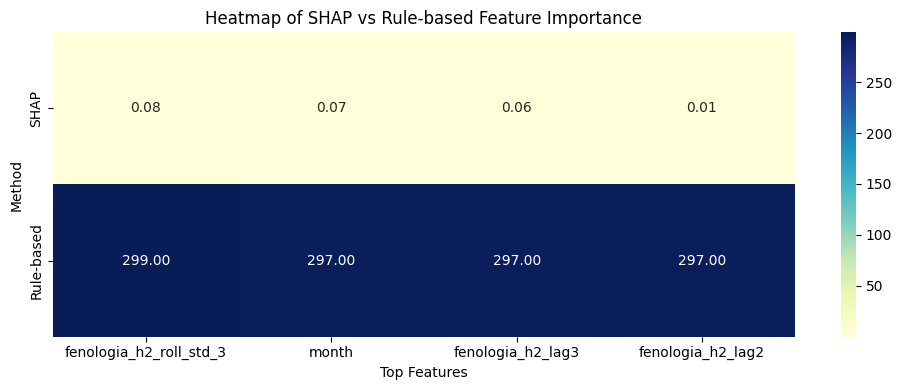

In [1]:
import pandas as pd
import numpy as np
import time
import shap
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

warnings.filterwarnings("ignore")
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# ---------------------------
# SHAP-Compatible Wrapper
# ---------------------------
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model
    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]
        return self.model(data).numpy()

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

# ---------------------------
# 2. Feature Scaling
# ---------------------------
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

# ---------------------------
# 3. Build GRU Model
# ---------------------------
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# 4. Bayesian Optimization
# ---------------------------
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=3)
    return optimizer.max['params']

# ---------------------------
# 5. Train & Evaluate Model
# ---------------------------
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# ---------------------------
# 6. Trust Score Computation
# ---------------------------
def compute_trust_metrics(shap_feats, rule_feats, k=10):
    shap_top_k = set(shap_feats[:k])
    rule_top = set(rule_feats)
    intersection = shap_top_k.intersection(rule_top)
    precision_at_k = len(intersection) / k
    coverage = len(intersection) / len(rule_top) if rule_top else 0
    jaccard = len(intersection) / len(shap_top_k.union(rule_top)) if shap_top_k.union(rule_top) else 0
    return precision_at_k, coverage, jaccard

# ---------------------------
# 7. Hybrid XAI with Trust Score + Heatmap
# ---------------------------
def hybrid_xai_analysis(model, X_2d, y, df, target_col):
    print("\n===== XAI Analysis (SHAP + Rules + Trust Score) =====")

    # --- SHAP ---
    wrapped_model = GRUModelWrapper(model)
    explainer = shap.Explainer(wrapped_model, X_2d)
    shap_vals = explainer(X_2d)
    mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
    if mean_abs_shap.ndim > 1:
        mean_abs_shap = mean_abs_shap.mean(axis=0)
    shap_top_idx = np.argsort(mean_abs_shap)[::-1]
    shap_top_feats = df.drop(columns=[target_col]).columns.to_numpy()[shap_top_idx].tolist()
    print("\nTop SHAP Features:", shap_top_feats[:10])

    # --- Association Rules ---
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    rule_feat_scores = {}
    all_rule_feats_set = set()

    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
                    all_rule_feats_set.add(feat)
        rule_feat_scores.update(feat_counts)
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"\nClass {cls} Rule Features: {[f for f, _ in sorted_feats]}")

    # --- Overlap ---
    overlapping_features = set(shap_top_feats[:10]).intersection(all_rule_feats_set)
    print("\nOverlapping Features:", list(overlapping_features))

    # --- Trust Metrics ---
    def trust_report(name, shap_list, rule_list):
        precision, coverage, jaccard = compute_trust_metrics(shap_list, rule_list)
        print(f"{name} → Precision@10: {precision:.2f}, Coverage: {coverage:.2f}, Jaccard: {jaccard:.2f}")
    print("\n--- Trust Metrics Summary ---")
    trust_report("SHAP vs Rules", shap_top_feats, list(all_rule_feats_set))
    trust_report("Overlap vs SHAP", list(overlapping_features), shap_top_feats)
    trust_report("Overlap vs Rules", list(overlapping_features), list(all_rule_feats_set))

    # --- Visualization: Heatmap of SHAP vs Rule-based Scores ---
    top_feats = shap_top_feats[:10]
    shap_dict = {feat: mean_abs_shap[df.columns.get_loc(feat)] for feat in top_feats}
    rule_dict = {feat: rule_feat_scores.get(feat, 0) for feat in top_feats}
    heatmap_df = pd.DataFrame([shap_dict, rule_dict], index=['SHAP', 'Rule-based'])
    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Heatmap of SHAP vs Rule-based Feature Importance")
    plt.xlabel("Top Features")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()

# ---------------------------
# 8. Main
# ---------------------------
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"
    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)
    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)
    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)
    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)
    print("\nRunning Hybrid XAI...")
    hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

if __name__ == "__main__":
    main()



Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9797    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9837    | 32.62     | 0.3618    | 24.19     | 88.27     |
| 4         | 0.9797    | 52.13     | 0.1941    | 29.35     | 67.79     |
| 5         | 0.9959    | 17.1      | 0.2678    | 29.7      | 92.85     |

Training Model...
Epoch 1/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4142 - loss: 1.2474 - val_accuracy: 0.7033 - val_loss: 0.8656
Epoch 2/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6661 - loss: 0.8372 - val_accuracy: 0.8699 - val_loss: 0.5491
Epoch 3/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8102 - loss: 0.5857 - val_accuracy: 0.9187 - val_loss: 0.3917
Epoch 4/29
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

ExactExplainer explainer: 1231it [02:28,  7.73it/s]                          



Top SHAP Features: ['fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2']

Class 1 Rule Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Rule Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Rule Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Rule Features: []

Overlapping Features: ['month', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2']

--- Trust Metrics Summary ---
SHAP vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57
Overlap vs SHAP → Precision@10: 0.40, Coverage: 1.00, Jaccard: 1.00
Overlap vs Rules → Precision@10: 0.40, Coverage: 0.57, Jaccard: 0.57

Generating Combined Feature Importance Line Plot...


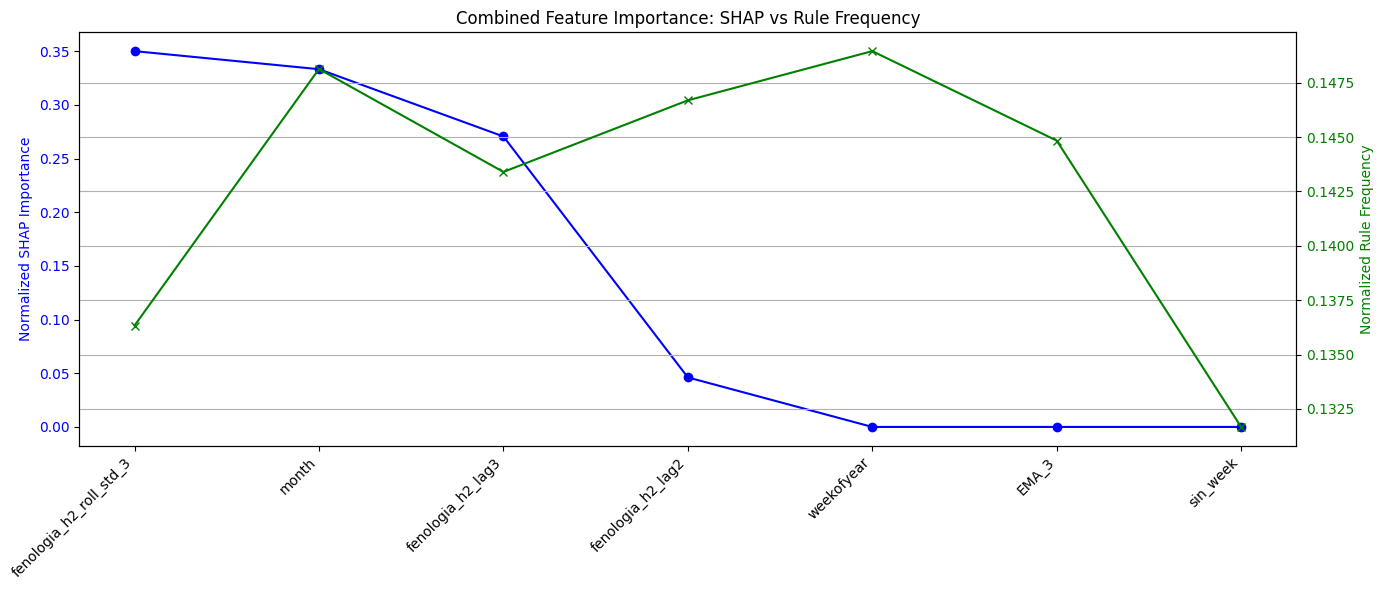

In [2]:
import pandas as pd
import numpy as np
import time
import shap
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

warnings.filterwarnings("ignore")
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]
        return self.model(data).numpy()

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=3)
    return optimizer.max['params']

def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

def compute_trust_metrics(shap_feats, rule_feats, k=10):
    shap_top_k = set(shap_feats[:k])
    rule_top = set(rule_feats)
    intersection = shap_top_k.intersection(rule_top)
    precision_at_k = len(intersection) / k
    coverage = len(intersection) / len(rule_top) if rule_top else 0
    jaccard = len(intersection) / len(shap_top_k.union(rule_top)) if shap_top_k.union(rule_top) else 0
    return precision_at_k, coverage, jaccard

def hybrid_xai_analysis(model, X_2d, y, df, target_col):
    print("\n===== XAI Analysis (SHAP + Rules + Trust Score) =====")

    wrapped_model = GRUModelWrapper(model)
    explainer = shap.Explainer(wrapped_model, X_2d)
    shap_vals = explainer(X_2d)
    mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
    if mean_abs_shap.ndim > 1:
        mean_abs_shap = mean_abs_shap.mean(axis=0)
    shap_top_idx = np.argsort(mean_abs_shap)[::-1]
    shap_top_feats = df.drop(columns=[target_col]).columns.to_numpy()[shap_top_idx].tolist()
    print("\nTop SHAP Features:", shap_top_feats[:10])

    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    rule_top_feats = {}
    all_rule_feats_set = set()

    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
                    all_rule_feats_set.add(feat)
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Rule Features: {[f for f, _ in sorted_feats]}")

    overlapping_features = set(shap_top_feats[:10]).intersection(all_rule_feats_set)
    print("\nOverlapping Features:", list(overlapping_features))

    def trust_report(name, shap_list, rule_list):
        precision, coverage, jaccard = compute_trust_metrics(shap_list, rule_list)
        print(f"{name} → Precision@10: {precision:.2f}, Coverage: {coverage:.2f}, Jaccard: {jaccard:.2f}")

    print("\n--- Trust Metrics Summary ---")
    trust_report("SHAP vs Rules", shap_top_feats, list(all_rule_feats_set))
    trust_report("Overlap vs SHAP", list(overlapping_features), shap_top_feats)
    trust_report("Overlap vs Rules", list(overlapping_features), list(all_rule_feats_set))

    # --- Combined Feature Importance Line Plot ---
    print("\nGenerating Combined Feature Importance Line Plot...")
    shap_vals_norm = mean_abs_shap / np.sum(mean_abs_shap)
    rule_feat_counts = {}
    for cls_feats in rule_top_feats.values():
        for feat, count in cls_feats:
            rule_feat_counts[feat] = rule_feat_counts.get(feat, 0) + count
    rule_feats_sorted = sorted(rule_feat_counts.items(), key=lambda x: x[1], reverse=True)
    rule_feats, rule_counts = zip(*rule_feats_sorted)
    rule_freq_norm = np.array(rule_counts) / np.sum(rule_counts)

    top_n = 20
    combined_features = list(dict.fromkeys(shap_top_feats[:top_n] + list(rule_feats[:top_n])))

    shap_dict = dict(zip(df.drop(columns=[target_col]).columns, shap_vals_norm))
    rule_dict = dict(zip(rule_feats, rule_freq_norm))
    shap_vals_plot = [shap_dict.get(f, 0) for f in combined_features]
    rule_vals_plot = [rule_dict.get(f, 0) for f in combined_features]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(combined_features, shap_vals_plot, label='Normalized SHAP', color='blue', marker='o')
    ax1.set_ylabel('Normalized SHAP Importance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(range(len(combined_features)))
    ax1.set_xticklabels(combined_features, rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(combined_features, rule_vals_plot, label='Normalized Rule Frequency', color='green', marker='x')
    ax2.set_ylabel('Normalized Rule Frequency', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Combined Feature Importance: SHAP vs Rule Frequency')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)

    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

    print("\nRunning Hybrid XAI...")
    hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

if __name__ == "__main__":
    main()

In [ ]:
# import pandas as pd
# import numpy as np
# import time
# import shap
# import warnings
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout
# from bayes_opt import BayesianOptimization
# from mlxtend.frequent_patterns import apriori, association_rules
# from mlxtend.preprocessing import TransactionEncoder

# warnings.filterwarnings("ignore")
# np.random.seed(42)
# import tensorflow as tf
# tf.random.set_seed(42)

# # ---------------------------
# # SHAP-Compatible Wrapper
# # ---------------------------
# class GRUModelWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, data):
#         if len(data.shape) == 2:
#             data = data[:, np.newaxis, :]  # Add time step dimension
#         return self.model(data).numpy()

# # ---------------------------
# # 1. Load and Preprocess Data
# # ---------------------------
# def load_and_preprocess_data(filepath):
#     df = pd.read_csv(filepath)
#     df.columns = df.columns.str.strip().str.replace('"', '')
#     df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
#     df.dropna(subset=['TIME'], inplace=True)
#     df.set_index('TIME', inplace=True)
#     df = df.apply(pd.to_numeric, errors='coerce')
#     df.dropna(axis=1, how='all', inplace=True)
#     target_col = 'fenologia_h2'
#     df[target_col].interpolate(method='linear', inplace=True)
#     df[target_col] = df[target_col] - 1
#     df.fillna(df.median(), inplace=True)
#     return df, target_col

# # ---------------------------
# # 2. Feature Scaling
# # ---------------------------
# def feature_scaling(df, target_col):
#     X = df.drop(columns=[target_col])
#     y = df[target_col]
#     scaler = MinMaxScaler()
#     X_scaled = scaler.fit_transform(X)
#     X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
#     return X_scaled, X_scaled_3d, y, scaler

# # ---------------------------
# # 3. Build GRU Model
# # ---------------------------
# def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
#     model = Sequential()
#     model.add(GRU(num_units, input_shape=input_shape))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(num_units // 2, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # ---------------------------
# # 4. Bayesian Optimization
# # ---------------------------
# def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
#     model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
#     history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
#     return np.max(history.history['val_accuracy'])

# def optimize_hyperparameters(X_train, y_train):
#     pbounds = {
#         'num_units': (32, 128),
#         'dropout_rate': (0.1, 0.5),
#         'epochs': (10, 30),
#         'batch_size': (16, 64)
#     }
#     optimizer = BayesianOptimization(
#         f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
#             num_units, dropout_rate, epochs, batch_size, X_train, y_train
#         ),
#         pbounds=pbounds,
#         random_state=42,
#         verbose=2
#     )
#     optimizer.maximize(init_points=2, n_iter=3)
#     return optimizer.max['params']

# # ---------------------------
# # 5. Train & Evaluate Model
# # ---------------------------
# def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
#     model = build_gru_model(
#         input_shape=(X_train.shape[1], X_train.shape[2]),
#         num_classes=4,
#         num_units=int(best_params['num_units']),
#         dropout_rate=float(best_params['dropout_rate'])
#     )
#     model.fit(
#         X_train, y_train,
#         epochs=int(best_params['epochs']),
#         batch_size=int(best_params['batch_size']),
#         validation_split=0.2,
#         verbose=1
#     )
#     y_pred = model.predict(X_test).argmax(axis=1)
#     print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
#     print("Classification Report:\n", classification_report(y_test, y_pred))
#     print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#     return model

# # ---------------------------
# # 6. Hybrid XAI: SHAP + Rules
# # ---------------------------
# def hybrid_xai_analysis(model, X_2d, y, df, target_col, top_k=10):
#     print("\n===== XAI Analysis (SHAP + Rules) =====")

#     # --- SHAP ---
#     print("\nTop SHAP Features:")
#     wrapped_model = GRUModelWrapper(model)
#     explainer = shap.Explainer(wrapped_model, X_2d)
#     shap_vals = explainer(X_2d)
#     mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)

#     shap_top_idx = np.argsort(mean_abs_shap)[-top_k:][::-1]
#     shap_top_idx = np.ravel(shap_top_idx)  # Ensure it's 1D
#     shap_top_feats = df.drop(columns=[target_col]).columns.to_numpy()[shap_top_idx].tolist()
#     print(shap_top_feats)

#     # --- Association Rules ---
#     print("\nTop Rule-Based Features:")
#     X = df.drop(columns=[target_col])
#     y_str = y.astype(str)
#     df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
#     df_disc['target'] = y_str
#     transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
#     te = TransactionEncoder()
#     df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
#     freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
#     rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

#     rule_top_feats = {}
#     for cls in y.unique():
#         class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
#         feat_counts = {}
#         for _, row in class_rules.iterrows():
#             for antecedent in row['antecedents']:
#                 if not antecedent.startswith('target='):
#                     feat = antecedent.split('=')[0]
#                     feat_counts[feat] = feat_counts.get(feat, 0) + 1
#         sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
#         rule_top_feats[cls] = sorted_feats
#         print(f"\nClass {cls} Features: {[f for f, _ in sorted_feats]}")

#     # --- Overlap Analysis ---
#     print("\nOverlap SHAP ↔ Rule-Based Features:")
#     for cls, feats in rule_top_feats.items():
#         rule_feats = {f for f, _ in feats}
#         overlap = set(shap_top_feats).intersection(rule_feats)
#         print(f"Class {cls} → Overlap: {overlap} (count: {len(overlap)})")

# # ---------------------------
# # 7. Main
# # ---------------------------
# def main():
#     train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
#     test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

#     df_train, target_col = load_and_preprocess_data(train_path)
#     X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

#     df_test, _ = load_and_preprocess_data(test_path)
#     X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

#     print("\nOptimizing Hyperparameters...")
#     best_params = optimize_hyperparameters(X_train_3d, y_train)

#     print("\nTraining Model...")
#     model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

#     print("\nRunning Hybrid XAI...")
#     hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

# if __name__ == "__main__":
#     main()



Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9797    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9837    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9797    | 22.93     | 0.1374    | 10.33     | 115.9     |
| 4         | 0.9959    | 18.36     | 0.1074    | 22.01     | 101.5     |
| 5         | 0.9959    | 16.71     | 0.2007    | 22.93     | 100.6     |

Training Model...
Epoch 1/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4253 - loss: 1.2511 - val_accuracy: 0.7276 - val_loss: 0.8311
Epoch 2/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.7901 - val_accuracy: 0.8821 - val_loss: 0.5019
Epoch 3/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss: 0.5179 - val_accuracy: 0.9268 - val_loss: 0.3465
Epoch 4/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

ExactExplainer explainer: 1231it [02:43,  7.08it/s]                          


['fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag3', 'fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag3', 'fenologia_h2_lag2', 'fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag3', 'month', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Top Rule-Based Features:

Class 1 Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Features: []

Overl

Displaying the association rules without any order


Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.8902    | 50.71     | 0.3672    | 14.46     | 38.13     |

Training Model...
Epoch 1/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4340 - loss: 1.2698 - val_accuracy: 0.5813 - val_loss: 0.9993
Epoch 2/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5473 - loss: 0.9849 - val_accuracy: 0.8211 - val_loss: 0.7604
Epoch 3/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7411 - loss: 0.7765 - val_accuracy: 0.7805 - val_loss: 0.6088
Epoch 4/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7553 - loss: 0.6469 - val_accuracy: 0.8008 - val_loss: 0.5039
Epoch 5/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7680 - loss: 0.5716 - val_accuracy: 0.8252 - val_loss: 0.4268
Epoch 6/24
30/30 ━━━━━━

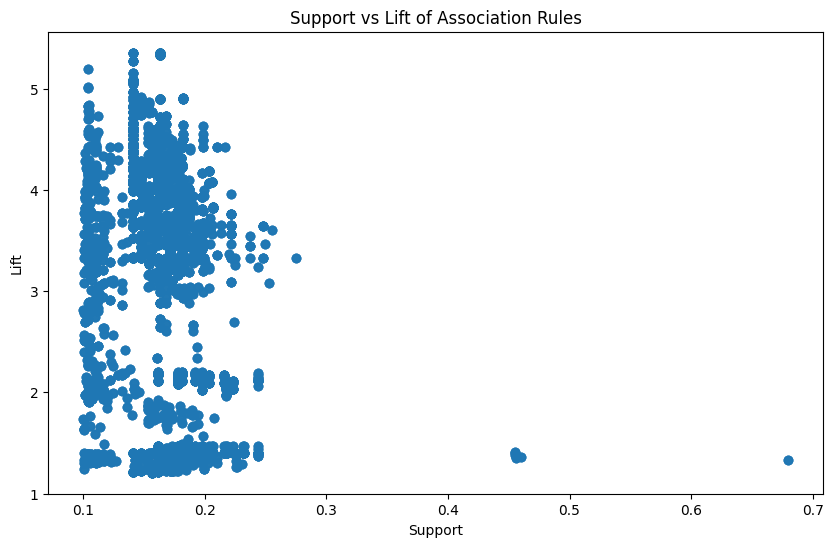


Class 1 Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'EMA_3', 'sin_week']

Class 3 Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'month', 'weekofyear', 'sin_week']

Class 0 Features: []


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import tensorflow as tf

# SHAP-Compatible Wrapper for GRU model
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]  # Add time step dimension
        return self.model(data).numpy()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

# Feature scaling
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

# Build GRU model
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Bayesian Optimization
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=1, n_iter=1)
    return optimizer.max['params']

# Train & evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# Association Rules Analysis
def rules_analysis(df, y, target_col, top_k=10):
    print("\n===== Association Rules Analysis =====")
    
    # --- Association Rules ---
    print("\nTop Rule-Based Features:")
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    # Print Association Rules
    print("\nAssociation Rules:")
    for idx, rule in rules.iterrows():
        print(f"Rule: {rule['antecedents']} => {rule['consequents']}, Support: {rule['support']}, Lift: {rule['lift']}")

    # Visualization of Association Rules
    rule_support = rules['support']
    rule_lift = rules['lift']
    plt.figure(figsize=(10, 6))
    plt.scatter(rule_support, rule_lift, alpha=0.5)
    plt.title("Support vs Lift of Association Rules")
    plt.xlabel("Support")
    plt.ylabel("Lift")
    plt.show()

    rule_top_feats = {}
    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Features: {[f for f, _ in sorted_feats]}")

# Main function
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)

    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

    # Perform Association Rules Analysis
    rules_analysis(df_train, y_train, target_col)

if __name__ == "__main__":
    main()


Displaying the SHAP feature importance with original feature names 

Epoch 1/10


C:\Users\hp\AppData\Local\Temp\ipykernel_17200\2941491952.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[target_col].interpolate(method='linear', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_17200\2941491952.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3150 - loss: 1.3259 - val_accuracy: 0.4878 - val_loss: 1.1173
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4518 - loss: 1.0991 - val_accuracy: 0.4959 - val_loss: 0.9144
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5569 - loss: 0.9002 - val_accuracy: 0.8740 - val_loss: 0.7400
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7635 - loss: 0.7648 - val_accuracy: 0.9106 - val_loss: 0.5976
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8150 - loss: 0.6240 - val_accuracy: 0.8699 - val_loss: 0.4968
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8185 - loss: 0.5466 - val_accuracy: 0.9268 - val_loss: 0.4129
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8632 - loss: 0.4437 - val_accuracy: 0.8862 - val_loss: 0.3544
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8870 - loss: 0.4022 - val_accuracy: 0.9390 - val_loss: 0.2992
E

ExactExplainer explainer: 1231it [02:58,  6.50it/s]                          


Top SHAP Features: ['fenologia_h2_roll_std_3', 'sin_week', 'weekofyear', 'month', 'EMA_3', 'fenologia_h2_lag2', 'fenologia_h2_lag3']


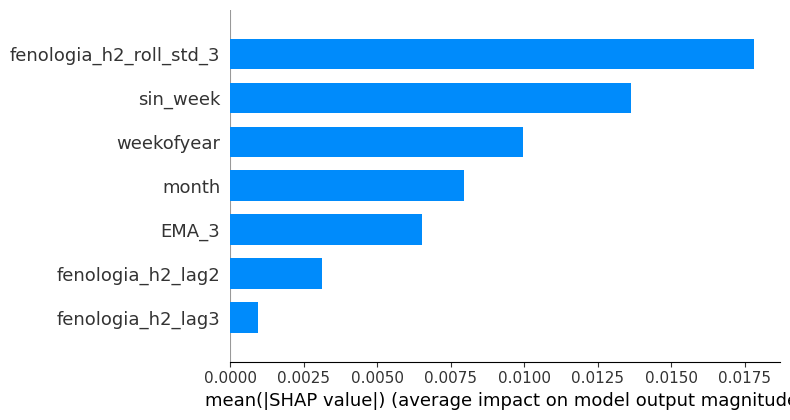

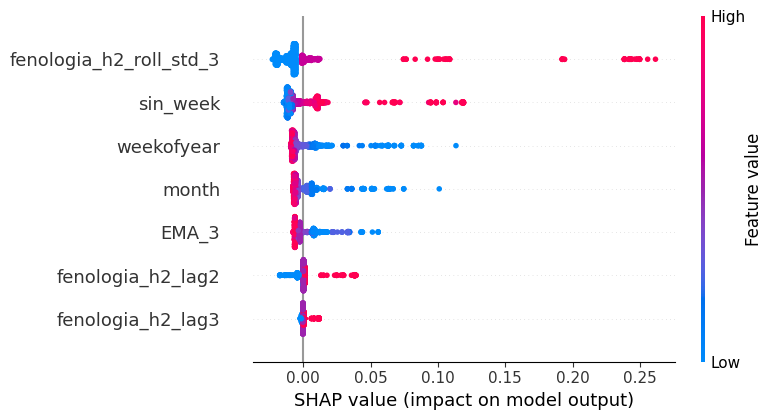

In [2]:
import pandas as pd
import numpy as np
import shap
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt

# --- SHAP-Compatible Wrapper for GRU Model ---
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.values  # Ensure it's a NumPy array
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]  # Add time step dimension
        return self.model(data).numpy()

# --- Load and Preprocess Data ---
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1  # Normalize target column
    df.fillna(df.median(), inplace=True)
    return df, target_col

# --- Feature Scaling ---
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # For GRU
    return X_scaled_df, X_scaled_3d, y, scaler

# --- Build GRU Model ---
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Train the Model ---
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    y_pred = model.predict(X_test).argmax(axis=1)
    accuracy = np.mean(y_pred == y_test)
    print(f"Model Accuracy: {accuracy:.4f}")
    return model

# --- SHAP Analysis ---
def shap_analysis(model, X_scaled_df, target_col, top_k=10):
    print("\n===== SHAP Analysis =====")
    wrapped_model = GRUModelWrapper(model)
    
    explainer = shap.Explainer(wrapped_model, X_scaled_df)
    shap_vals = explainer(X_scaled_df)

    # If SHAP returns multi-class output
    if isinstance(shap_vals.values, list) or shap_vals.values.ndim == 3:
        shap_values_to_plot = shap_vals[..., 0]
    else:
        shap_values_to_plot = shap_vals

    # Compute mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values_to_plot.values).mean(axis=0)
    shap_top_idx = np.argsort(mean_abs_shap)[-top_k:][::-1]
    shap_top_feats = X_scaled_df.columns[shap_top_idx].tolist()

    print(f"Top SHAP Features: {shap_top_feats}")

    # SHAP Visualizations with original feature names
    shap.summary_plot(shap_values_to_plot, X_scaled_df, plot_type="bar")
    shap.summary_plot(shap_values_to_plot, X_scaled_df)

# --- Main Execution Flow ---
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_df, X_train_3d, y_train, scaler = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_df, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    model = train_and_evaluate_model(X_train_3d, y_train, X_test_3d, y_test)

    # Run SHAP with feature names preserved
    shap_analysis(model, X_train_df, target_col)

if __name__ == "__main__":
    main()


Displaying the Association rules in descending order based on lift

C:\Users\hp\AppData\Local\Temp\ipykernel_17200\3439379724.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[target_col].interpolate(method='linear', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_17200\3439379724.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo


Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9878    | 33.98     | 0.4803    | 24.64     | 89.47     |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 2         | 0.9309    | 50.71     | 0.3672    | 14.46     | 38.13     |

Training Model...
Epoch 1/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3563 - loss: 1.3339 - val_accuracy: 0.4878 - val_loss: 1.0870
Epoch 2/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4654 - loss: 1.0734 - val_accuracy: 0.5081 - val_loss: 0.8871
Epoch 3/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5872 - loss: 0.9150 - val_accuracy: 0.8862 - val_loss: 0.7085
Epoch 4/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7354 - loss: 0.7471 - val_accuracy: 0.9268 - val_loss: 0.5703
Epoch 5/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8015 - loss: 0.5962 - val_accuracy: 0.8659 - val_loss: 0.4659
Epoch 6/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8021 - loss: 0.5433 - val_accuracy: 0.8699 - val_loss: 0.3834
Epoch 7/24
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8273 - loss: 0.4782 - val_accuracy: 0.9309 - val_loss: 0.3182
Epoch 8/24
30/30 ━━━━━━━

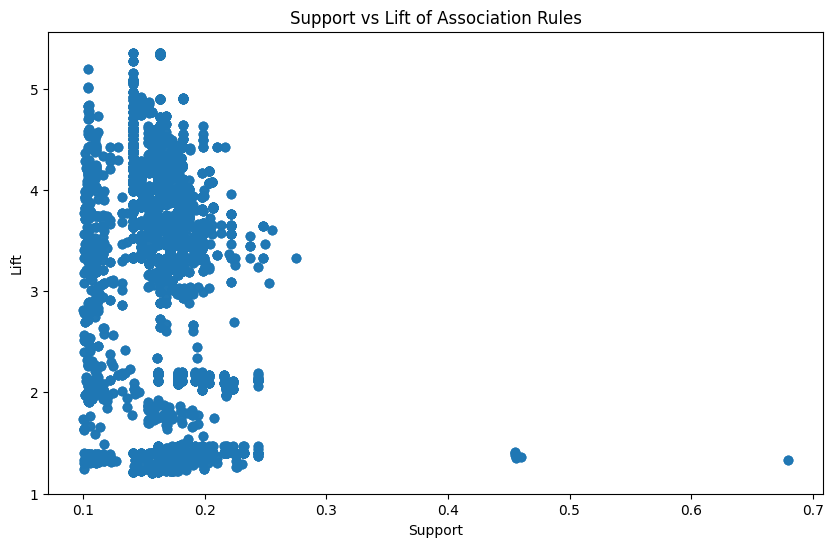


Class 1 Features: ['EMA_3', 'sin_week', 'month', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']

Class 2 Features: ['fenologia_h2_lag2', 'fenologia_h2_lag3', 'weekofyear', 'month', 'fenologia_h2_roll_std_3', 'sin_week', 'EMA_3']

Class 3 Features: ['EMA_3', 'fenologia_h2_roll_std_3', 'month', 'fenologia_h2_lag3', 'fenologia_h2_lag2', 'weekofyear', 'sin_week']

Class 0 Features: []


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import tensorflow as tf

# SHAP-Compatible Wrapper for GRU model
class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]  # Add time step dimension
        return self.model(data).numpy()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

# Feature scaling
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

# Build GRU model
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Bayesian Optimization
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=1, n_iter=1)
    return optimizer.max['params']

# Train & evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# Association Rules Analysis (sorting by lift)
def rules_analysis(df, y, target_col, top_k=10):
    print("\n===== Association Rules Analysis =====")
    
    # --- Association Rules ---
    print("\nTop Rule-Based Features:")
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)

    # Sort rules by lift in descending order
    rules_sorted_by_lift = rules.sort_values(by='lift', ascending=False)

    # Print sorted Association Rules
    print("\nSorted Association Rules by Lift:")
    for idx, rule in rules_sorted_by_lift.iterrows():
        print(f"Rule: {rule['antecedents']} => {rule['consequents']}, Support: {rule['support']}, Lift: {rule['lift']}")

    # Visualization of Association Rules
    rule_support = rules_sorted_by_lift['support']
    rule_lift = rules_sorted_by_lift['lift']
    plt.figure(figsize=(10, 6))
    plt.scatter(rule_support, rule_lift, alpha=0.5)
    plt.title("Support vs Lift of Association Rules")
    plt.xlabel("Support")
    plt.ylabel("Lift")
    plt.show()

    rule_top_feats = {}
    for cls in y.unique():
        class_rules = rules_sorted_by_lift[rules_sorted_by_lift['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Features: {[f for f, _ in sorted_feats]}")

# Main function
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)

    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)

    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)

    # Perform Association Rules Analysis
    rules_analysis(df_train, y_train, target_col)

if __name__ == "__main__":
    main()


Quantify Trust using:

precision@k

coverage

Jaccard similarity

Statistically Test the overlap between SHAP and rule-based features using permutation testing.

Retrain a GRU model using only the overlapping features and compare performance to the full-feature model.

In [1]:
import pandas as pd
import numpy as np
import shap
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from bayes_opt import BayesianOptimization
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import tensorflow as tf

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

class GRUModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, data):
        if len(data.shape) == 2:
            data = data[:, np.newaxis, :]
        return self.model(data).numpy()

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    target_col = 'fenologia_h2'
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1
    df.fillna(df.median(), inplace=True)
    return df, target_col

def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_scaled_3d, y, scaler

def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), 4, int(num_units), dropout_rate)
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_split=0.2, verbose=0)
    return np.max(history.history['val_accuracy'])

def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (10, 30),
        'batch_size': (16, 64)
    }
    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=3)
    return optimizer.max['params']

def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )
    model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

def calculate_trust_metrics(shap_top_feats, rule_top_feats):
    metrics = {}
    precision_list = []
    coverage_classes = 0
    total_jaccard = 0
    for cls, feats in rule_top_feats.items():
        rule_feats = set(f for f, _ in feats)
        overlap = set(shap_top_feats).intersection(rule_feats)
        precision_k = len(overlap) / len(shap_top_feats)
        precision_list.append(precision_k)
        if len(feats) > 0:
            coverage_classes += 1
        union_len = len(set(shap_top_feats).union(rule_feats))
        intersection_len = len(overlap)
        jaccard = intersection_len / union_len if union_len > 0 else 0
        total_jaccard += jaccard
    metrics["Precision@10"] = np.mean(precision_list)
    metrics["Jaccard Similarity"] = total_jaccard / len(rule_top_feats)
    metrics["Coverage"] = coverage_classes / len(rule_top_feats)
    return metrics


def hybrid_xai_analysis(model, X_2d, y, df, target_col, top_k=10):
    print("\n===== XAI Analysis (SHAP + Rules) =====")
    print("\nTop SHAP Features:")
    wrapped_model = GRUModelWrapper(model)
    explainer = shap.Explainer(wrapped_model, X_2d)
    shap_vals = explainer(X_2d)
    mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
    shap_top_idx = np.argsort(mean_abs_shap)[-top_k:][::-1]
    shap_top_feats = [str(df.drop(columns=[target_col]).columns[i]) for i in shap_top_idx]
    print(shap_top_feats)

    print("\nTop Rule-Based Features:")
    X = df.drop(columns=[target_col])
    y_str = y.astype(str)
    df_disc = X.apply(lambda col: pd.qcut(col, q=4, duplicates='drop').astype(str))
    df_disc['target'] = y_str
    transactions = [[f"{col}={val}" for col, val in row.items()] for _, row in df_disc.iterrows()]
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    freq_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.2)
    rule_top_feats = {}
    for cls in y.unique():
        class_rules = rules[rules['consequents'].apply(lambda x: f'target={cls}' in x)]
        feat_counts = {}
        for _, row in class_rules.iterrows():
            for antecedent in row['antecedents']:
                if not antecedent.startswith('target='):
                    feat = antecedent.split('=')[0]
                    feat_counts[feat] = feat_counts.get(feat, 0) + 1
        sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
        rule_top_feats[cls] = sorted_feats
        print(f"\nClass {cls} Features: {[f for f, _ in sorted_feats]}")

    print("\nOverlap SHAP ↔ Rule-Based Features:")
    for cls, feats in rule_top_feats.items():
        rule_feats = {f for f, _ in feats}
        overlap = set(shap_top_feats).intersection(rule_feats)
        print(f"Class {cls} → Overlap: {overlap} (count: {len(overlap)})")

    print("\nTrust Metrics Summary:")
    trust_metrics = calculate_trust_metrics(shap_top_feats, rule_top_feats)
    for metric, value in trust_metrics.items():
        print(f"{metric}: {value:.4f}")



def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"
    df_train, target_col = load_and_preprocess_data(train_path)
    X_train_2d, X_train_3d, y_train, _ = feature_scaling(df_train, target_col)
    df_test, _ = load_and_preprocess_data(test_path)
    X_test_2d, X_test_3d, y_test, _ = feature_scaling(df_test, target_col)
    print("\nOptimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train_3d, y_train)
    print("\nTraining Model...")
    model = train_and_evaluate_model(X_train_3d, X_test_3d, y_train, y_test, best_params)
    print("\nRunning Hybrid XAI...")
    hybrid_xai_analysis(model, X_train_2d, y_train, df_train, target_col)

if __name__ == "__main__":
    main()



Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9837    | 33.98     | 0.4803    | 24.64     | 89.47     |
| 2         | 0.9797    | 23.49     | 0.1624    | 11.16     | 115.2     |
| 3         | 0.9878    | 32.62     | 0.3618    | 24.19     | 88.27     |
| 4         | 0.9959    | 18.36     | 0.1074    | 22.01     | 101.5     |
| 5         | 0.9878    | 19.01     | 0.2987    | 20.48     | 99.28     |

Training Model...
Epoch 1/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4336 - loss: 1.2292 - val_accuracy: 0.7033 - val_loss: 0.8493
Epoch 2/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6783 - loss: 0.8017 - val_accuracy: 0.8821 - val_loss: 0.5276
Epoch 3/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8322 - loss: 0.5434 - val_accuracy: 0.9228 - val_loss: 0.3703
Epoch 4/22
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - a

ExactExplainer explainer: 1231it [03:47,  5.27it/s]                          


["Index(['fenologia_h2_lag2', 'fenologia_h2_lag3', 'month',\n       'fenologia_h2_roll_std_3'],\n      dtype='object')", "Index(['fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3',\n       'month'],\n      dtype='object')", "Index(['fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3',\n       'fenologia_h2_lag3'],\n      dtype='object')", "Index(['fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3',\n       'fenologia_h2_lag3'],\n      dtype='object')", "Index(['fenologia_h2_roll_std_3', 'fenologia_h2_lag2', 'month',\n       'fenologia_h2_lag3'],\n      dtype='object')", "Index(['fenologia_h2_lag2', 'month', 'fenologia_h2_roll_std_3',\n       'fenologia_h2_lag3'],\n      dtype='object')", "Index(['fenologia_h2_lag2', 'month', 'fenologia_h2_lag3',\n       'fenologia_h2_roll_std_3'],\n      dtype='object')"]

Top Rule-Based Features:

Class 1 Features: ['EMA_3', 'month', 'sin_week', 'weekofyear', 'fenologia_h2_lag2', 'fenologia_h2_lag3', 'fenologia_h2_roll_std_3']


Keeping olny overlapping features 
extracting overlapping SHAP + rule-based features and save training and testing files with only these features, while retaining the TIME and target columns.

In [4]:
import pandas as pd

# Define input file paths
train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

# Define selected hybrid XAI features + TIME + target
selected_features = [
    'month',
    'fenologia_h2_lag2',
    'fenologia_h2_lag3',
    'fenologia_h2_roll_std_3',
    'TIME',
    'fenologia_h2'
]

# Load training and testing data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Strip any whitespace or quotes from column names
df_train.columns = df_train.columns.str.strip().str.replace('"', '')
df_test.columns = df_test.columns.str.strip().str.replace('"', '')

# Keep only selected features (if any are missing, will raise error)
df_train_selected = df_train[selected_features]
df_test_selected = df_test[selected_features]

# Save new files
output_train_path = train_path.replace(".csv", "_hybrid_XAI_selected_features.csv")
output_test_path = test_path.replace(".csv", "_hybrid_XAI_selected_features.csv")

df_train_selected.to_csv(output_train_path, index=False)
df_test_selected.to_csv(output_test_path, index=False)

print("Filtered files saved:")
print(f"Train → {output_train_path}")
print(f"Test  → {output_test_path}")


Filtered files saved:
Train → E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected_hybrid_XAI_selected_features.csv
Test  → E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected_hybrid_XAI_selected_features.csv


REtraining model on overlapping features 



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import psutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.fftpack import fft
import warnings

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ============================================
# 1. Data Loading and Preprocessing
# ============================================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h2'
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1

    

    df.fillna(df.median(), inplace=True)
    return df, target_col

# ============================================
# 2. Feature Scaling
# ============================================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D for RNN
    return X_scaled, y, scaler

# ============================================
# 3. Build GRU Model
# ============================================
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================================
# 4. Bayesian Optimization Objective
# ============================================
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(num_units),
        dropout_rate=dropout_rate
    )
    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )
    return np.max(history.history['val_accuracy'])

# ============================================
# 5. Optimize Hyperparameters
# ============================================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ============================================
# 6. Train & Evaluate Model
# ============================================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )

    start_train = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    training_time = time.time() - start_train

    start_infer = time.time()
    y_pred = model.predict(X_test).argmax(axis=1)
    inference_time = (time.time() - start_infer) / len(X_test)

    # Calculate total testing time
    testing_time = time.time() - start_infer

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\n===== Evaluation =====")
    print(f"Accuracy: {acc:.4f}")
    print("Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", cm)

    model.save("temp_model.h5", include_optimizer=False)
    model_size = os.path.getsize("temp_model.h5") / (1024 ** 2)
    os.remove("temp_model.h5")

    total_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    ram_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 ** 2)

    print("\n===== Model Metrics =====")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Inference/sample: {inference_time:.6f}s")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Trainable Params: {total_params:,}")
    print(f"RAM Usage: {ram_usage:.2f} MB")

    return model, history

# ============================================
# 7. Main
# ============================================
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected_hybrid_XAI_selected_features.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected_hybrid_XAI_selected_features.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    print("\n Optimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\n Best Params:", best_params)

    print("\n Training Final GRU Model...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

if __name__ == "__main__":
    main()



 Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9756    | 33.98     | 0.4803    | 86.6      | 89.47     |
| 2         | 0.9919    | 23.49     | 0.1624    | 52.9      | 115.2     |
| 3         | 0.9756    | 44.85     | 0.3832    | 51.03     | 125.1     |
| 4         | 0.9797    | 55.96     | 0.1849    | 59.09     | 49.61     |
| 5         | 0.9837    | 30.6      | 0.3099    | 71.6      | 59.96     |
| 6         | 0.9837    | 22.97     | 0.3185    | 53.09     | 116.6     |
| 7         | 0.9919    | 22.45     | 0.1024    | 51.48     | 115.3     |
| 8         | 0.9756    | 23.86     | 0.2556    | 51.96     | 114.0     |
| 9         | 0.9756    | 62.6      | 0.3838    | 99.69     | 67.9      |
| 10        | 0.9756    | 38.63     | 0.1642    | 90.1      | 41.26     |
| 11        | 0.9837    | 23.88     | 0.2827    | 50.69     | 115.4     |
| 12  


===== Evaluation =====
Accuracy: 0.9656
Report:
               precision    recall  f1-score   support

           0     1.0000    0.4762    0.6452        42
           1     0.8964    0.9956    0.9434       226
           2     0.9961    0.9921    0.9941       509
           3     1.0000    0.9722    0.9859        36

    accuracy                         0.9656       813
   macro avg     0.9731    0.8590    0.8921       813
weighted avg     0.9687    0.9656    0.9616       813

Confusion Matrix:
 [[ 20  22   0   0]
 [  0 225   1   0]
 [  0   4 505   0]
 [  0   0   1  35]]

===== Model Metrics =====
Training Time: 30.35s
Inference/sample: 0.000737s
Testing Time: 0.60s
Model Size: 0.24 MB
Trainable Params: 57,189
RAM Usage: 1598.91 MB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import psutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.fftpack import fft
import warnings

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ============================================
# 1. Data Loading and Preprocessing
# ============================================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h2'
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1

    

    df.fillna(df.median(), inplace=True)
    return df, target_col

# ============================================
# 2. Feature Scaling
# ============================================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D for RNN
    return X_scaled, y, scaler

# ============================================
# 3. Build GRU Model
# ============================================
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================================
# 4. Bayesian Optimization Objective
# ============================================
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(num_units),
        dropout_rate=dropout_rate
    )
    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )
    return np.max(history.history['val_accuracy'])

# ============================================
# 5. Optimize Hyperparameters
# ============================================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ============================================
# 6. Train & Evaluate Model
# ============================================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )

    start_train = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    training_time = time.time() - start_train

    start_infer = time.time()
    y_pred = model.predict(X_test).argmax(axis=1)
    inference_time = (time.time() - start_infer) / len(X_test)

    # Calculate total testing time
    testing_time = time.time() - start_infer

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\n===== Evaluation =====")
    print(f"Accuracy: {acc:.4f}")
    print("Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", cm)

    model.save("temp_model.h5", include_optimizer=False)
    model_size = os.path.getsize("temp_model.h5") / (1024 ** 2)
    os.remove("temp_model.h5")

    total_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    ram_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 ** 2)

    print("\n===== Model Metrics =====")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Inference/sample: {inference_time:.6f}s")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Trainable Params: {total_params:,}")
    print(f"RAM Usage: {ram_usage:.2f} MB")

    return model, history

# ============================================
# 7. Main
# ============================================
def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected_hybrid_XAI_selected_features.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected_hybrid_XAI_selected_features.csv"

    df_train, target_col = load_and_preprocess_data(train_path)
    X_train, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    print("\n Optimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\n Best Params:", best_params)

    print("\n Training Final GRU Model...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

if __name__ == "__main__":
    main()



 Optimizing Hyperparameters...
|   iter    |  target   | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------
| 1         | 0.9919    | 33.98     | 0.4803    | 86.6      | 89.47     |
| 2         | 0.9837    | 23.49     | 0.1624    | 52.9      | 115.2     |
| 3         | 0.9837    | 44.85     | 0.3832    | 51.03     | 125.1     |
| 4         | 0.9675    | 55.96     | 0.1849    | 59.09     | 49.61     |
| 5         | 0.9837    | 30.6      | 0.3099    | 71.6      | 59.96     |
| 6         | 0.9919    | 16.26     | 0.4218    | 88.64     | 84.65     |
| 7         | 0.9919    | 22.31     | 0.218     | 99.29     | 121.0     |
| 8         | 0.9959    | 33.12     | 0.3515    | 85.97     | 89.07     |
| 9         | 0.9959    | 31.42     | 0.457     | 83.58     | 89.22     |
| 10        | 0.9959    | 29.55     | 0.1953    | 85.32     | 86.22     |
| 11        | 0.9959    | 34.24     | 0.1608    | 82.97     | 84.09     |
| 12  


===== Evaluation =====
Accuracy: 0.9643
Report:
               precision    recall  f1-score   support

           0     0.9091    0.4762    0.6250        42
           1     0.8992    0.9867    0.9409       226
           2     0.9961    0.9941    0.9951       509
           3     1.0000    0.9722    0.9859        36

    accuracy                         0.9643       813
   macro avg     0.9511    0.8573    0.8867       813
weighted avg     0.9648    0.9643    0.9605       813

Confusion Matrix:
 [[ 20  22   0   0]
 [  2 223   1   0]
 [  0   3 506   0]
 [  0   0   1  35]]

===== Model Metrics =====
Training Time: 21.32s
Inference/sample: 0.000721s
Testing Time: 0.59s
Model Size: 0.13 MB
Trainable Params: 29,505
RAM Usage: 1067.59 MB


: 